In [1]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import data_handler as dh
from omnifold_bdt import unbinned_omnifold
import modplot # Just contains functions for plot formatting
import h5py as h5

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

## Opening data files and storing it
### In this example, we're using the Z+jets dataset which has 6 observables in each event
### The Pythia data will be our MC/reconstructed MC data
### The Herwig data will be our "True" and experimental data

In [3]:
# This is the number of data points you want to use and the number of unfolding iterations
num_train_data = 100000
itnum = 3

In [4]:
data_dir = "/global/homes/r/rmilton/m3246/rmilton/omnifold_paper_plots/datasets/"
synthetic_file_path = data_dir + "train_pythia.h5"
nature_file_path = data_dir + "train_herwig.h5"

synthetic  =  h5.File(synthetic_file_path, 'r')
nature = h5.File(nature_file_path, 'r')
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

In [5]:
synthetic_obs = {'gen_mass':synthetic['gen_subs'][:num_train_data, 0], 'gen_width':synthetic['gen_subs'][:num_train_data, 1], 'gen_mult':synthetic['gen_subs'][:num_train_data, 2],
                 'gen_sdmass':synthetic['gen_subs'][:num_train_data, 3], 'gen_zg':synthetic['gen_subs'][:num_train_data, 4], 'gen_tau21':synthetic['gen_subs'][:num_train_data, 5],
                 'reco_mass':synthetic['reco_subs'][:num_train_data, 0], 'reco_width':synthetic['reco_subs'][:num_train_data, 1], 'reco_mult':synthetic['reco_subs'][:num_train_data, 2],
                 'reco_sdmass':synthetic['reco_subs'][:num_train_data, 3], 'reco_zg':synthetic['reco_subs'][:num_train_data, 4], 'reco_tau21':synthetic['reco_subs'][:num_train_data, 5]}
nature_obs    = {'gen_mass':nature['gen_subs'][:num_train_data, 0], 'gen_width':nature['gen_subs'][:num_train_data, 1], 'gen_mult':nature['gen_subs'][:num_train_data, 2],
                 'gen_sdmass':nature['gen_subs'][:num_train_data, 3], 'gen_zg':nature['gen_subs'][:num_train_data, 4], 'gen_tau21':nature['gen_subs'][:num_train_data, 5],
                 'reco_mass':nature['reco_subs'][:num_train_data, 0], 'reco_width':nature['reco_subs'][:num_train_data, 1], 'reco_mult':nature['reco_subs'][:num_train_data, 2],
                 'reco_sdmass':nature['reco_subs'][:num_train_data, 3], 'reco_zg':nature['reco_subs'][:num_train_data, 4], 'reco_tau21':nature['reco_subs'][:num_train_data, 5]}

### Storing our observables in dictionaries

In [6]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mult'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_width'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau21'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zg'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_sdmass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}

In [7]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():

    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic_obs, 'gen'), ob['func'](synthetic_obs, 'reco')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature_obs, 'gen'), ob['func'](nature_obs, 'reco')
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


### Now we start unfolding
### We store our data in numpy arrays for the BDT unfolding
### The shape of the data will be (num_events, num_features)
### The shape of the pass reco and pass truth should be (num_events,) 
### If all events pass truth or pass reco, just make these arrays all true

In [8]:
synthetic_pass_reco = (synthetic['reco_jets'][:num_train_data,0]>150)
nature_pass_reco = (nature['reco_jets'][:num_train_data,0]>150)

mc_entries = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries = np.asarray([(obs[obkey]['dataobs'][nature_pass_reco]) for obkey in obs_multifold]).T
pass_truth_mask = np.full(len(sim_entries), True)

In [9]:
weights, MC_test, sim_test, pass_reco_test = unbinned_omnifold(
    mc_entries, 
    sim_entries, 
    measured_entries,
    synthetic_pass_reco, 
    pass_truth_mask,
    itnum)

Starting iteration 0
Starting iteration 1
Starting iteration 2


### We now have our unfolded weights
### The function splits the data into train/test data
### The test data and the associated weights are output
### weights contains the weights from all iterations and from step 1 and 2
#### To weight the MC data, apply weights[-1, 1]
#### To weight the sim data, apply weights[-1, 0][pass_reco_test]


### Plotting our unfolded distributions!

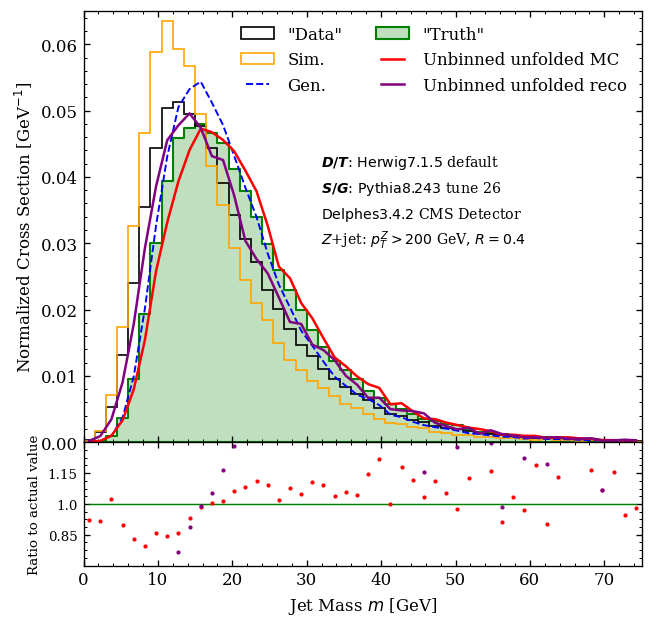

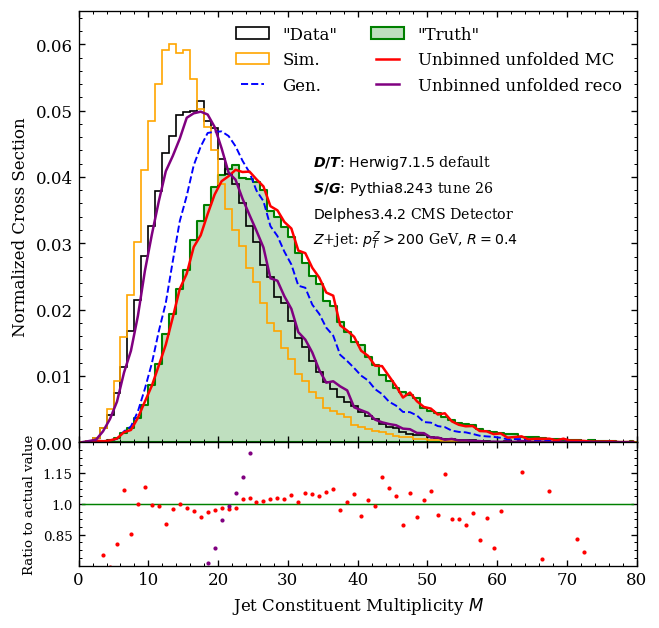

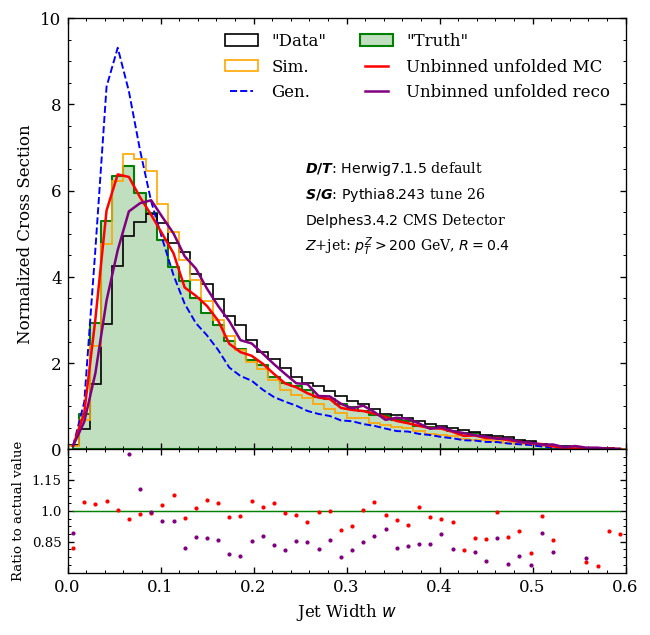

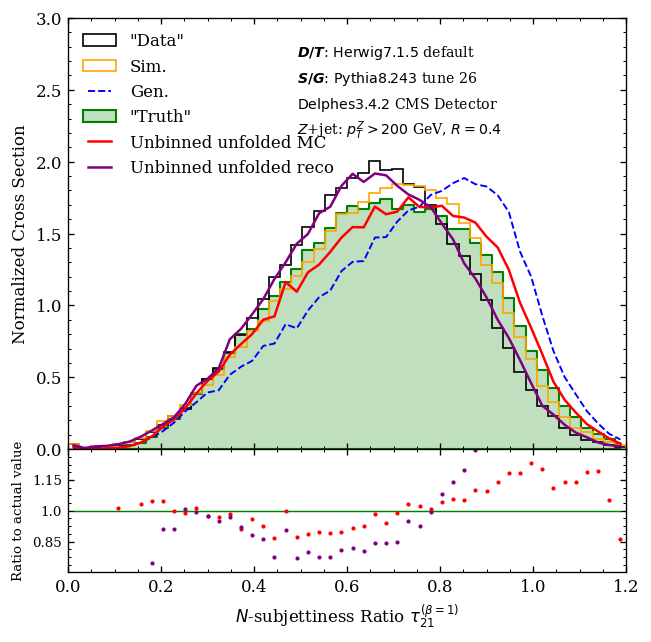

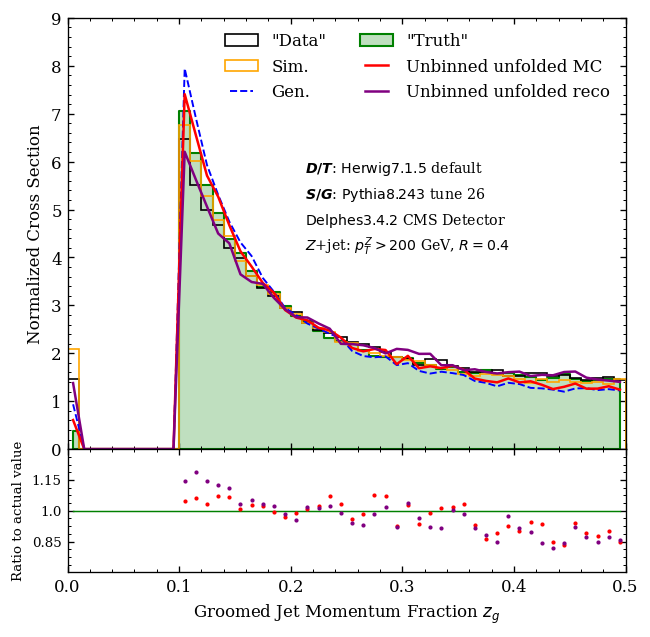

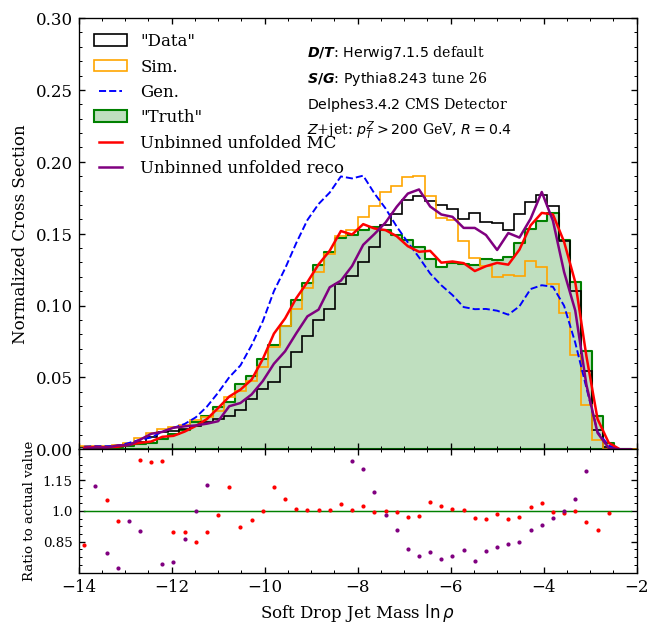

In [14]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='"Data"', **hist_style)
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    hist_range_low, hist_range_high = ob['xlim'][0], ob['xlim'][1]

    # Getting histogram for unfolded MC distribution and plotting
    unfolded_MC_hist, unfolded_MC_bin_edges = np.histogram(MC_test[:,i],
                                                           weights = weights[-1, 1],
                                                           bins = ob['bins_mc'],
                                                           range = [hist_range_low, hist_range_high],
                                                           density=True)
    unfolded_MC_bin_centers = (unfolded_MC_bin_edges[:-1] + unfolded_MC_bin_edges[1:]) / 2
    ax0.plot(unfolded_MC_bin_centers, unfolded_MC_hist, label = "Unbinned unfolded MC", color='red')

    # Getting histogram for unfolded MC reco distribution and plotting
    unfolded_reco_hist, unfolded_reco_bin_edges = np.histogram(sim_test[:,i],
                                                           weights = weights[-1, 0][pass_reco_test],
                                                           bins = ob['bins_det'],
                                                           range = [hist_range_low, hist_range_high],
                                                           density=True)
    unfolded_reco_bin_centers = (unfolded_reco_bin_edges[:-1] + unfolded_reco_bin_edges[1:]) / 2
    ax0.plot(unfolded_reco_bin_centers, unfolded_reco_hist, label = "Unbinned unfolded reco", color='purple')
    

    # Bottom panel contains the ratios of unfolded distributions to actual distribution
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    ax1.set_ylabel("Ratio to actual value")
    
    unfolded_MC_truth_ratio = unfolded_MC_hist /(ob['truth_hist'] + 10**-50)
    # Plotting unfolded MC ratio to truth
    ax1.errorbar(
        unfolded_MC_bin_centers,
        unfolded_MC_truth_ratio,
        color = 'red',
        **modplot.style('errorbar')
    )

    unfolded_reco_data_ratio = unfolded_MC_hist /(ob['data_hist'] + 10**-50)
    # Plotting unfolded reco ratio to data
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    ax1.errorbar(
        unfolded_MC_bin_centers,
        unfolded_reco_data_ratio,
        color = 'purple',
        **modplot.style('errorbar')
    )
    
    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\boldsymbol{D/T}$: $\mathsf{Herwig 7.1.5}$ default',
                  line_1=r'$\boldsymbol{S/G}$: $\mathsf{Pythia 8.243}$ tune 26',
                  line_2=r'$\mathsf{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')